In [1]:
import numpy as np
import sklearn as sk
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.cluster import KMeans
from sklearn import metrics
import math
from yellowbrick.cluster import SilhouetteVisualizer
from pyclustering.cluster.kmedians import kmedians
from matplotlib import cm

In [2]:
n = 1000

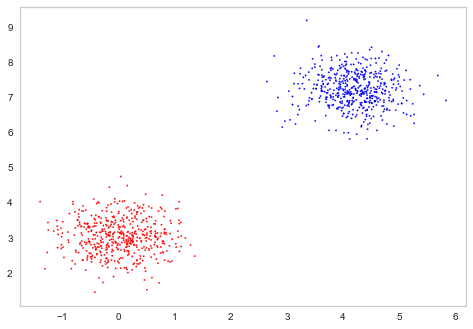

In [3]:
blobs, blob_labels = sk.datasets.make_blobs(n_samples=n, n_features=2, center_box=(0, 10.0), centers=2, cluster_std=0.5, random_state=1)
blobs = blobs.round(3)
plt.scatter(blobs[:, 0], blobs[:, 1], c=blob_labels, cmap="bwr", s=2)
plt.grid(which='major');

In [4]:
k = 2
d = 2 #0.00005 #0.000005 #0.0000005
eps = 0.1
X = blobs
n_initial = len(X) # the size of the current point set, a.k.a. n is all of the initial points

In [5]:
def visualize_splitting(Z, c_centers, lines, X, initial_bbox, title="Sub-Cell Construction"):
    plt.figure(figsize=(8, 6))

    # Plot the initial bounding box
    bbox = np.array(initial_bbox)
    plt.plot(bbox[:, 0], bbox[:, 1], color='green', linestyle='-', linewidth=1) #label='Initial Bounding Box'

    # Plot the original points
    plt.scatter(X[:, 0], X[:, 1], color='blue', marker='.', label='Original Points')

    # Plot cell centers
    centers = np.array(c_centers)
    plt.scatter(centers[:, 0], centers[:, 1], color='red', marker='x', label='Cell Centers', s=45)

    # Plot the splitting lines
    for line in lines:
        for rect_coords in line:
            rect = patches.Rectangle(
                (rect_coords[0][0], rect_coords[1][0]),  # Bottom-left and top-right corner
                rect_coords[0][1] - rect_coords[0][0],   # Width
                rect_coords[1][1] - rect_coords[1][0],   # Height
                edgecolor='green', facecolor='none')
            plt.gca().add_patch(rect)

    plt.title(title)
    plt.axis("off")
    plt.legend(loc='upper left', bbox_to_anchor=(0.03, 1.08), frameon=True, framealpha=1, edgecolor='black')
    plt.grid(False)
    plt.show()

In [6]:
def recursive_split(X, cell, k, d, eps, opt, n_initial, delta, nr_of_cells, cs, i, lines, Z, c_centers):
    x1, x2, y1, y2 = cell
    points_in_cell = X[(X[:, 0] >= x1) & (X[:, 0] < x2) & (X[:, 1] >= y1) & (X[:, 1] < y2)]
    
    threshold = ((delta)*opt) / pow(2, i)
    print("Threshold value:", round(threshold, 5), "Points in cell:", len(points_in_cell))
    if len(points_in_cell) < threshold:
        # If there are less than the threshold number of points, it's a light cell
        # First time this is checked, it checks the grid g**i if it is light (step #3)
        # Afterwards when it recurs it does step #3.4, marks c as a light cell and adds it to Z
        # Also when it recurs it does step #3.5 here (delete c from Y) as the light cell c will no longer be recured
        
        if len(points_in_cell) >= 1: 
            #print("\033[1m Points in light cell:\n", points_in_cell, "\033[0;0m")
            # If c is not empty (this already checks step #4)
            Z.append(points_in_cell)
            # Save the center coordinates for step #4.1
            c_centers.append(((x1 + x2) / 2, (y1 + y2) / 2))
    else: 
        #print("Current number of cells: " + str(nr_of_cells))
        # Cell counter, each time a cell gets split into 4 subcells the total increases by 3
        nr_of_cells = nr_of_cells + 3

        # The would-be number of cells if the below code executes
        # Does not allow to create more subcells than cs
        if i>=0 and len(points_in_cell)!=0:# and i >= np.log(delta * opt)+1: # and nr_of_cells <= cs:
        
            # Step #3.1 if c is heavy then: Split the cell
            # First time this executes - only if g**i is heavy and splits it into 4 sub-cells c1, c2, c3, c4 (step #3)
            # Afterwards the level of each cell goes to g**i-1, with side length 2**i-1 with each recursion
            i = i - 1
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            
            lines.append([
                ((x1, mid_x), (y1, mid_y)),  # Top-left
                ((mid_x, x2), (y1, mid_y)),  # Top-right
                ((x1, mid_x), (mid_y, y2)),  # Bottom-left
                ((mid_x, x2), (mid_y, y2))])  # Bottom-right
            
            cells = [
                (x1, mid_x, y1, mid_y),  # Top-left
                (mid_x, x2, y1, mid_y),  # Top-right
                (x1, mid_x, mid_y, y2),  # Bottom-left
                (mid_x, x2, mid_y, y2)   # Bottom-right
            ]
            # Step #3.2 and #3.3 as it implicitly adds c1, c2, c3, c4 to Y with each recursion below
            for sub_cell in cells:
                recursive_split(points_in_cell, sub_cell, k, d, eps, opt, n_initial, delta, nr_of_cells, cs, i, lines,
                                Z, c_centers)
    return Z, c_centers, lines

In [7]:
def coreset(Z, rep_c, delta, cs, eps):
    
    # rep_c = c_centers = representative center point of a cell
    # n_c = number of  points in each cell
    n_c = [len(c) for c in Z]
    
    # S = pairs respective center coordinates with number of points in each cell
    S = []
    for index in range(0, len(rep_c)):
        S.append([rep_c[index], n_c[index]])
    #print(rep_c, n_c)
    if len(S) > cs*(1+eps) or len(S) == 0:
        return None # failure indication
    else:
        return S

In [8]:
def coreset_construction(X, k, d, eps, n_initial):
    
    if X.size > 0: 
        print("The array is non-empty, proceeding with coreset construction algorithm")
        
        # Step #1: Define the boundaries of the coordinate plane, at the start let Y be the only cell in grid g^(log(D))
        x_min, x_max, y_min, y_max = min(X[:, 0]), max(X[:, 0]), min(X[:, 1]), max(X[:, 1])
        Y = x_min, x_max, y_min, y_max
        
        # Calculate delta
        #delta below 6 fails to construct coreset
        delta = ( 1 / ( (4*k*np.sqrt(d)) * (np.log(n_initial)+1) ) )
        if delta < 1: delta = 6
        #delta = ( 1 / ( (4*k*np.sqrt(d)) * (np.log(n_initial)+1) ) ) * pow( ( eps / (14*np.sqrt(d)) ), d)
        print("delta =", round(delta, 4))
        # Calculate coreset size
        cs = math.ceil(2/delta + (np.log(n_initial) + 2) * k * pow(2, d))
        print("cs =", cs)
        DELTA = 6 # take DELTA as an arbitrary constant, lets say 5
        # Opt = number of guesses for opt approx., round up: (delta+1) * log_base(1 + eps)(DELTA) * (sqrt(2))
        Opt =  math.ceil( (delta+1) * (np.log(np.sqrt(DELTA))/np.log(1 + eps)) * np.sqrt(2) )
        print("Number of guesses for opt approximation =", Opt)

        for j in range(0, Opt):
            print("\nIteration j = " + str(j) + ", with approximation Opt = (1+eps)^j = " + str(pow((1+eps), j)) + "\n")
            
            # Cell counter
            nr_of_cells = 1
            # i-th iteration tracking for recursive alg
            i = DELTA
            # Lines defining sub-cell boundries
            lines = []
            # Step #0: arr to store light cells c
            Z = []
            # Cell centers
            c_centers = []

            # Start the recursive splitting, here Opt = (1+eps)^j
            Z, c_centers, lines = recursive_split(X, Y, k, d, eps, pow((1+eps), j), n_initial,
                                                  delta, nr_of_cells, cs, i, lines, Z, c_centers)
            # Start the coreset calculation
            S = coreset(Z, c_centers, delta, cs, eps)
                        
            if S is not None:
                print("\n Coreset constructed: \n", S, ", of size:", len(S))
                
                initial_bbox = [[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max], [x_min, y_min]]
                visualize_splitting(Z, c_centers, lines, X, initial_bbox)
                
                return S
        return "Coreset could not be constructed"
    else:
        return "The array is empty."

The array is non-empty, proceeding with coreset construction algorithm
delta = 6
cs = 72
Number of guesses for opt approximation = 94

Iteration j = 0, with approximation Opt = (1+eps)^j = 1.0

Threshold value: 0.09375 Points in cell: 998
Threshold value: 0.1875 Points in cell: 500
Threshold value: 0.375 Points in cell: 287
Threshold value: 0.75 Points in cell: 8
Threshold value: 1.5 Points in cell: 0
Threshold value: 1.5 Points in cell: 0
Threshold value: 1.5 Points in cell: 1
Threshold value: 1.5 Points in cell: 7
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 2
Threshold value: 3.0 Points in cell: 3
Threshold value: 6.0 Points in cell: 0
Threshold value: 6.0 Points in cell: 0
Threshold value: 6.0 Points in cell: 2
Threshold value: 6.0 Points in cell: 1
Threshold value: 0.75 Points in cell: 37
Threshold value: 1.5 Points in cell: 4
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 0
Threshol

Threshold value: 3.3 Points in cell: 8
Threshold value: 6.6 Points in cell: 4
Threshold value: 6.6 Points in cell: 1
Threshold value: 6.6 Points in cell: 1
Threshold value: 6.6 Points in cell: 2
Threshold value: 3.3 Points in cell: 7
Threshold value: 6.6 Points in cell: 2
Threshold value: 6.6 Points in cell: 1
Threshold value: 6.6 Points in cell: 2
Threshold value: 6.6 Points in cell: 2
Threshold value: 3.3 Points in cell: 16
Threshold value: 6.6 Points in cell: 5
Threshold value: 6.6 Points in cell: 5
Threshold value: 6.6 Points in cell: 2
Threshold value: 6.6 Points in cell: 4
Threshold value: 3.3 Points in cell: 13
Threshold value: 6.6 Points in cell: 4
Threshold value: 6.6 Points in cell: 1
Threshold value: 6.6 Points in cell: 3
Threshold value: 6.6 Points in cell: 5
Threshold value: 1.65 Points in cell: 42
Threshold value: 3.3 Points in cell: 9
Threshold value: 6.6 Points in cell: 2
Threshold value: 6.6 Points in cell: 2
Threshold value: 6.6 Points in cell: 1
Threshold value: 6.6 

Threshold value: 7.26 Points in cell: 2
Threshold value: 7.26 Points in cell: 1
Threshold value: 7.26 Points in cell: 5
Threshold value: 3.63 Points in cell: 11
Threshold value: 7.26 Points in cell: 2
Threshold value: 7.26 Points in cell: 4
Threshold value: 7.26 Points in cell: 4
Threshold value: 7.26 Points in cell: 1
Threshold value: 3.63 Points in cell: 12
Threshold value: 7.26 Points in cell: 1
Threshold value: 7.26 Points in cell: 4
Threshold value: 7.26 Points in cell: 5
Threshold value: 7.26 Points in cell: 2
Threshold value: 3.63 Points in cell: 15
Threshold value: 7.26 Points in cell: 4
Threshold value: 7.26 Points in cell: 4
Threshold value: 7.26 Points in cell: 2
Threshold value: 7.26 Points in cell: 5
Threshold value: 0.45375 Points in cell: 182
Threshold value: 0.9075 Points in cell: 12
Threshold value: 1.815 Points in cell: 0
Threshold value: 1.815 Points in cell: 0
Threshold value: 1.815 Points in cell: 9
Threshold value: 3.63 Points in cell: 3
Threshold value: 3.63 Poin

Threshold value: 2.19615 Points in cell: 6
Threshold value: 4.3923 Points in cell: 1
Threshold value: 4.3923 Points in cell: 1
Threshold value: 4.3923 Points in cell: 0
Threshold value: 4.3923 Points in cell: 4
Threshold value: 2.19615 Points in cell: 20
Threshold value: 4.3923 Points in cell: 2
Threshold value: 4.3923 Points in cell: 7
Threshold value: 8.7846 Points in cell: 0
Threshold value: 8.7846 Points in cell: 3
Threshold value: 8.7846 Points in cell: 1
Threshold value: 8.7846 Points in cell: 3
Threshold value: 4.3923 Points in cell: 1
Threshold value: 4.3923 Points in cell: 10
Threshold value: 8.7846 Points in cell: 2
Threshold value: 8.7846 Points in cell: 0
Threshold value: 8.7846 Points in cell: 2
Threshold value: 8.7846 Points in cell: 6
Threshold value: 2.19615 Points in cell: 8
Threshold value: 4.3923 Points in cell: 0
Threshold value: 4.3923 Points in cell: 3
Threshold value: 4.3923 Points in cell: 1
Threshold value: 4.3923 Points in cell: 4
Threshold value: 2.19615 Poin

Threshold value: 2.41577 Points in cell: 15
Threshold value: 4.83153 Points in cell: 3
Threshold value: 4.83153 Points in cell: 4
Threshold value: 4.83153 Points in cell: 4
Threshold value: 4.83153 Points in cell: 4
Threshold value: 2.41577 Points in cell: 39
Threshold value: 4.83153 Points in cell: 9
Threshold value: 9.66306 Points in cell: 4
Threshold value: 9.66306 Points in cell: 1
Threshold value: 9.66306 Points in cell: 2
Threshold value: 9.66306 Points in cell: 2
Threshold value: 4.83153 Points in cell: 12
Threshold value: 9.66306 Points in cell: 0
Threshold value: 9.66306 Points in cell: 4
Threshold value: 9.66306 Points in cell: 3
Threshold value: 9.66306 Points in cell: 5
Threshold value: 4.83153 Points in cell: 9
Threshold value: 9.66306 Points in cell: 3
Threshold value: 9.66306 Points in cell: 4
Threshold value: 9.66306 Points in cell: 1
Threshold value: 9.66306 Points in cell: 1
Threshold value: 4.83153 Points in cell: 9
Threshold value: 9.66306 Points in cell: 1
Threshol

Threshold value: 2.92308 Points in cell: 0
Threshold value: 2.92308 Points in cell: 0
Threshold value: 2.92308 Points in cell: 9
Threshold value: 5.84615 Points in cell: 3
Threshold value: 5.84615 Points in cell: 1
Threshold value: 5.84615 Points in cell: 0
Threshold value: 5.84615 Points in cell: 5
Threshold value: 2.92308 Points in cell: 3
Threshold value: 5.84615 Points in cell: 0
Threshold value: 5.84615 Points in cell: 0
Threshold value: 5.84615 Points in cell: 1
Threshold value: 5.84615 Points in cell: 2
Threshold value: 1.46154 Points in cell: 1
Threshold value: 1.46154 Points in cell: 154
Threshold value: 2.92308 Points in cell: 27
Threshold value: 5.84615 Points in cell: 6
Threshold value: 11.6923 Points in cell: 0
Threshold value: 11.6923 Points in cell: 1
Threshold value: 11.6923 Points in cell: 2
Threshold value: 11.6923 Points in cell: 3
Threshold value: 5.84615 Points in cell: 5
Threshold value: 5.84615 Points in cell: 6
Threshold value: 11.6923 Points in cell: 2
Threshol

Threshold value: 3.53692 Points in cell: 39
Threshold value: 7.07384 Points in cell: 9
Threshold value: 14.14769 Points in cell: 4
Threshold value: 14.14769 Points in cell: 1
Threshold value: 14.14769 Points in cell: 2
Threshold value: 14.14769 Points in cell: 2
Threshold value: 7.07384 Points in cell: 12
Threshold value: 14.14769 Points in cell: 0
Threshold value: 14.14769 Points in cell: 4
Threshold value: 14.14769 Points in cell: 3
Threshold value: 14.14769 Points in cell: 5
Threshold value: 7.07384 Points in cell: 9
Threshold value: 14.14769 Points in cell: 3
Threshold value: 14.14769 Points in cell: 4
Threshold value: 14.14769 Points in cell: 1
Threshold value: 14.14769 Points in cell: 1
Threshold value: 7.07384 Points in cell: 9
Threshold value: 14.14769 Points in cell: 1
Threshold value: 14.14769 Points in cell: 3
Threshold value: 14.14769 Points in cell: 3
Threshold value: 14.14769 Points in cell: 2
Threshold value: 3.53692 Points in cell: 5
Threshold value: 7.07384 Points in c

Threshold value: 18.83057 Points in cell: 2
Threshold value: 18.83057 Points in cell: 6
Threshold value: 18.83057 Points in cell: 3
Threshold value: 9.41529 Points in cell: 12
Threshold value: 18.83057 Points in cell: 3
Threshold value: 18.83057 Points in cell: 5
Threshold value: 18.83057 Points in cell: 3
Threshold value: 18.83057 Points in cell: 1
Threshold value: 9.41529 Points in cell: 13
Threshold value: 18.83057 Points in cell: 3
Threshold value: 18.83057 Points in cell: 3
Threshold value: 18.83057 Points in cell: 4
Threshold value: 18.83057 Points in cell: 3
Threshold value: 4.70764 Points in cell: 57
Threshold value: 9.41529 Points in cell: 17
Threshold value: 18.83057 Points in cell: 2
Threshold value: 18.83057 Points in cell: 6
Threshold value: 18.83057 Points in cell: 4
Threshold value: 18.83057 Points in cell: 5
Threshold value: 9.41529 Points in cell: 19
Threshold value: 18.83057 Points in cell: 8
Threshold value: 18.83057 Points in cell: 5
Threshold value: 18.83057 Points

Threshold value: 1.56647 Points in cell: 287
Threshold value: 3.13294 Points in cell: 8
Threshold value: 6.26587 Points in cell: 0
Threshold value: 6.26587 Points in cell: 0
Threshold value: 6.26587 Points in cell: 1
Threshold value: 6.26587 Points in cell: 7
Threshold value: 12.53174 Points in cell: 1
Threshold value: 12.53174 Points in cell: 1
Threshold value: 12.53174 Points in cell: 2
Threshold value: 12.53174 Points in cell: 3
Threshold value: 3.13294 Points in cell: 37
Threshold value: 6.26587 Points in cell: 4
Threshold value: 6.26587 Points in cell: 0
Threshold value: 6.26587 Points in cell: 15
Threshold value: 12.53174 Points in cell: 0
Threshold value: 12.53174 Points in cell: 2
Threshold value: 12.53174 Points in cell: 5
Threshold value: 12.53174 Points in cell: 8
Threshold value: 6.26587 Points in cell: 18
Threshold value: 12.53174 Points in cell: 5
Threshold value: 12.53174 Points in cell: 1
Threshold value: 12.53174 Points in cell: 3
Threshold value: 12.53174 Points in ce

Threshold value: 33.3595 Points in cell: 3
Threshold value: 16.67975 Points in cell: 21
Threshold value: 33.3595 Points in cell: 6
Threshold value: 33.3595 Points in cell: 4
Threshold value: 33.3595 Points in cell: 6
Threshold value: 33.3595 Points in cell: 5
Threshold value: 8.33988 Points in cell: 45
Threshold value: 16.67975 Points in cell: 16
Threshold value: 16.67975 Points in cell: 7
Threshold value: 16.67975 Points in cell: 14
Threshold value: 16.67975 Points in cell: 8
Threshold value: 4.16994 Points in cell: 15
Threshold value: 8.33988 Points in cell: 5
Threshold value: 8.33988 Points in cell: 0
Threshold value: 8.33988 Points in cell: 9
Threshold value: 16.67975 Points in cell: 5
Threshold value: 16.67975 Points in cell: 1
Threshold value: 16.67975 Points in cell: 2
Threshold value: 16.67975 Points in cell: 1
Threshold value: 8.33988 Points in cell: 1
Threshold value: 2.08497 Points in cell: 81
Threshold value: 4.16994 Points in cell: 2
Threshold value: 4.16994 Points in cell

Threshold value: 0.92341 Points in cell: 998
Threshold value: 1.84682 Points in cell: 500
Threshold value: 3.69365 Points in cell: 287
Threshold value: 7.3873 Points in cell: 8
Threshold value: 14.7746 Points in cell: 0
Threshold value: 14.7746 Points in cell: 0
Threshold value: 14.7746 Points in cell: 1
Threshold value: 14.7746 Points in cell: 7
Threshold value: 7.3873 Points in cell: 37
Threshold value: 14.7746 Points in cell: 4
Threshold value: 14.7746 Points in cell: 0
Threshold value: 14.7746 Points in cell: 15
Threshold value: 29.5492 Points in cell: 0
Threshold value: 29.5492 Points in cell: 2
Threshold value: 29.5492 Points in cell: 5
Threshold value: 29.5492 Points in cell: 8
Threshold value: 14.7746 Points in cell: 18
Threshold value: 29.5492 Points in cell: 5
Threshold value: 29.5492 Points in cell: 1
Threshold value: 29.5492 Points in cell: 3
Threshold value: 29.5492 Points in cell: 9
Threshold value: 7.3873 Points in cell: 53
Threshold value: 14.7746 Points in cell: 6
Thre

Threshold value: 52.34821 Points in cell: 13
Threshold value: 52.34821 Points in cell: 7
Threshold value: 52.34821 Points in cell: 6
Threshold value: 26.1741 Points in cell: 6
Threshold value: 13.08705 Points in cell: 1
Threshold value: 6.54353 Points in cell: 96
Threshold value: 13.08705 Points in cell: 24
Threshold value: 26.1741 Points in cell: 3
Threshold value: 26.1741 Points in cell: 17
Threshold value: 26.1741 Points in cell: 1
Threshold value: 26.1741 Points in cell: 3
Threshold value: 13.08705 Points in cell: 69
Threshold value: 26.1741 Points in cell: 27
Threshold value: 52.34821 Points in cell: 9
Threshold value: 52.34821 Points in cell: 12
Threshold value: 52.34821 Points in cell: 3
Threshold value: 52.34821 Points in cell: 3
Threshold value: 26.1741 Points in cell: 26
Threshold value: 26.1741 Points in cell: 8
Threshold value: 26.1741 Points in cell: 8
Threshold value: 13.08705 Points in cell: 0
Threshold value: 13.08705 Points in cell: 3
Threshold value: 6.54353 Points in

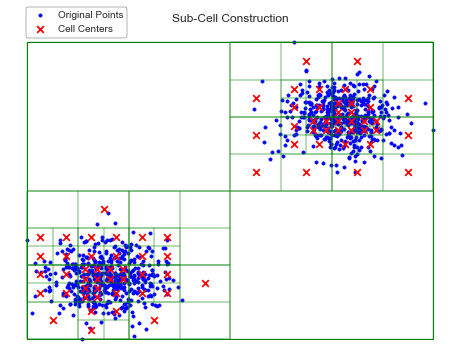

In [9]:
S = coreset_construction(X, k, d, eps, n_initial)

# K means for blobs

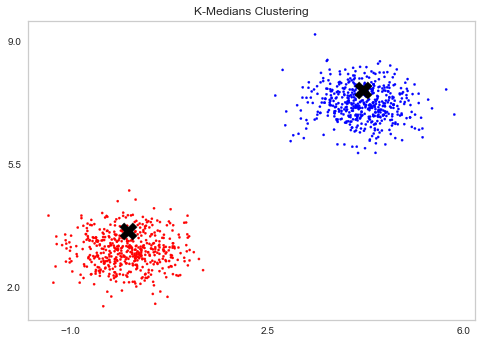

In [11]:
#testing
kmedians_instance = kmedians(X, X[np.random.permutation(X.shape[0])[:2],:])
kmedians_instance.process();

clusters = kmedians_instance.get_clusters()
y_kmedians = np.zeros([X.shape[0]])
y_kmedians[clusters[0]]=0
y_kmedians[clusters[1]]=1

plt.scatter(X[:, 0], X[:, 1], c=y_kmedians, s=5, cmap='bwr')
centers = np.array(kmedians_instance.get_medians())
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, alpha=1, marker='X')
plt.title('K-Medians Clustering')
plt.grid(which='major')

x_ticks = [-1,2.5,6]
plt.xticks(x_ticks)

y_ticks = [2,5.5,9]
plt.yticks(y_ticks)
plt.show()

plt.show()

In [12]:
def calculate_inertia(data, centroids, labels):
    inertia = 0.0
    for i in range(len(data)):
        cluster_center = centroids[labels[i]]
        inertia += np.sum((data[i] - cluster_center) ** 2)
    return inertia

In [13]:
#testing
silhouette_score = metrics.silhouette_score(X, y_kmedians, metric='manhattan')
inertia = calculate_inertia(X, centers, blob_labels)

print(f"Silhouette Score: {silhouette_score}") #how well-separated the clusters are
print(f"Inertia: {inertia}") # how far the points within a cluster are from the center of that cluster.

Silhouette Score: 0.8627793833245833
Inertia: 734.8139650000005


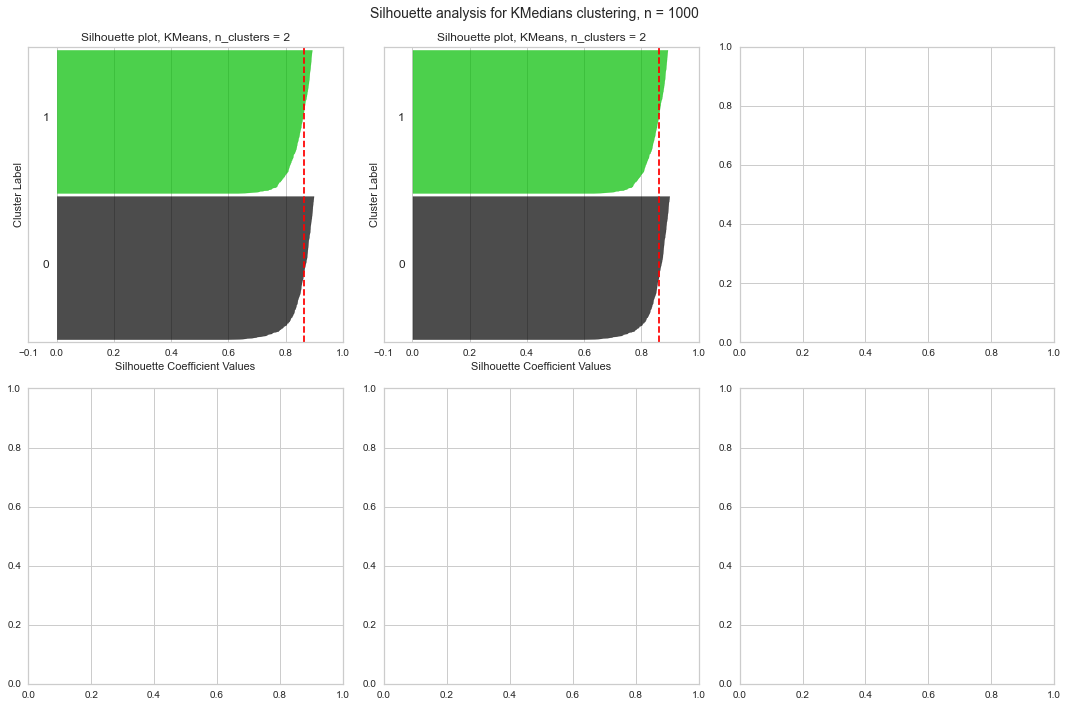

In [27]:
def plot_silhouette_analysis(data, clusterer, cluster_labels, n_clusters, ax):
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(cluster_labels) + (n_clusters + 1) * 10])

    silhouette_avg = metrics.silhouette_score(data, cluster_labels, metric='manhattan')

    sample_silhouette_values = metrics.silhouette_samples(data, cluster_labels)

    y_lower = 10
    for j in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(j) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))
        
        y_lower = y_upper + 10

    ax.set_title(f"Silhouette plot, KMeans, n_clusters = {n_clusters}")
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster Label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# Example usage:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

# Assuming clusterer and cluster_labels are computed outside the function
#for i, n_clusters in enumerate([2, 3, 4, 5, 6, 7]):
plot_silhouette_analysis(X, kmedians_instance, y_kmedians, k, axs[0])
plot_silhouette_analysis(X, kmedians_instance, y_kmedians, k, axs[1])
    #kmedians_instance, cluster_labels, n_clusters, axs[i]
    
plt.suptitle(f'Silhouette analysis for KMedians clustering, n = {n}', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
visualizer = SilhouetteVisualizer(kmedians_instance, colors='yellowbrick',
                                  title=f"1. Blobs. Silhouette plot, KMeans n = {X.shape[0]}, k = {k}")
visualizer.fit(X)
visualizer.finalize()

In [11]:
silhouette_score = metrics.silhouette_score(X, y_kmeans)
inertia = kmeans.inertia_

print(f"Silhouette Score: {silhouette_score}") #how well-separated the clusters are
print(f"Inertia: {inertia}") # how far the points within a cluster are from the center of that cluster.

Silhouette Score: 0.8489182937774936
Inertia: 505.15761447599994


# K means for coreset of blobs

In [12]:
coordinates = np.array([item[0] for item in S])
coreset_array = coordinates.reshape(-1, 2)
coreset_array[0:5]

array([[-0.943375 ,  1.9305   ],
       [-0.2659375,  1.68875  ],
       [-0.2659375,  2.17225  ],
       [ 0.1856875,  2.17225  ],
       [-1.1691875,  2.65575  ]])

C:\Users\Stasius\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


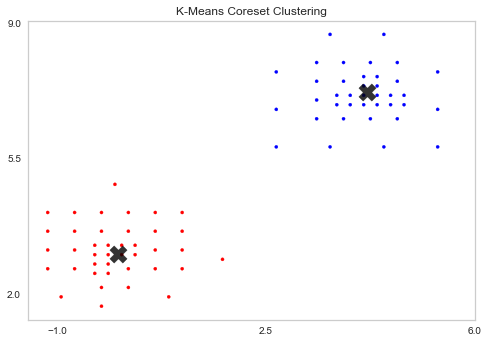

In [79]:
corekmeans = KMeans(n_clusters=2, random_state=0)
y_corekmeans = corekmeans.fit_predict(coreset_array, sample_weight= [item[1] for item in S])

plt.scatter(coreset_array[:, 0], coreset_array[:, 1], c=y_corekmeans, s=10, cmap='bwr')
corecenters = corekmeans.cluster_centers_
plt.scatter(corecenters[:, 0], corecenters[:, 1], c='black', s=300, alpha=0.8, marker='X')
plt.title('K-Means Coreset Clustering')
plt.grid(which='major')

x_ticks = [-1,2.5,6]
plt.xticks(x_ticks)

y_ticks = [2,5.5,9]
plt.yticks(y_ticks)
plt.show()

plt.show()

In [14]:
silhouette_score_core = metrics.silhouette_score(coreset_array, y_corekmeans)
inertia_core = corekmeans.inertia_

print(f"Silhouette Score: {silhouette_score_core}")
print(f"Inertia: {inertia_core}")

Silhouette Score: 0.778845282045127
Inertia: 586.6118167717266


# Half circles (moons)

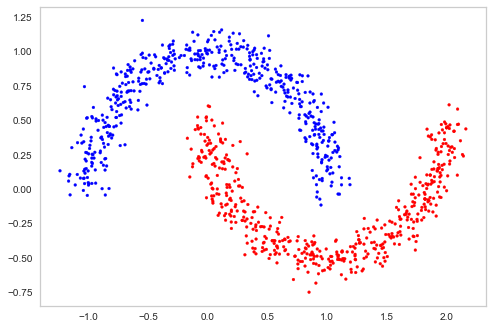

In [107]:
moons, moon_labels = sk.datasets.make_moons(n_samples=n, random_state=1, noise = 0.08)
moons = moons.round(3)
plt.scatter(moons[:, 0], moons[:, 1], c=moon_labels, cmap="bwr", s=8)
plt.grid(which='major');

The array is non-empty, proceeding with coreset construction algorithm
delta = 6
cs = 72
Number of guesses for opt approximation = 94

Iteration j = 0, with approximation Opt = (1+eps)^j = 1.0

Threshold value: 0.09375 Points in cell: 998
Threshold value: 0.1875 Points in cell: 157
Threshold value: 0.375 Points in cell: 0
Threshold value: 0.375 Points in cell: 19
Threshold value: 0.75 Points in cell: 0
Threshold value: 0.75 Points in cell: 0
Threshold value: 0.75 Points in cell: 0
Threshold value: 0.75 Points in cell: 19
Threshold value: 1.5 Points in cell: 0
Threshold value: 1.5 Points in cell: 9
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 3
Threshold value: 6.0 Points in cell: 0
Threshold value: 6.0 Points in cell: 0
Threshold value: 6.0 Points in cell: 2
Threshold value: 6.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 4
Threshold value: 6.0 Points in cell: 2
Threshold value: 6.0 Points in cell: 1
Thres

Threshold value: 6.0 Points in cell: 2
Threshold value: 6.0 Points in cell: 2
Threshold value: 3.0 Points in cell: 3
Threshold value: 6.0 Points in cell: 1
Threshold value: 6.0 Points in cell: 1
Threshold value: 6.0 Points in cell: 0
Threshold value: 6.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 5
Threshold value: 6.0 Points in cell: 1
Threshold value: 6.0 Points in cell: 1
Threshold value: 6.0 Points in cell: 1
Threshold value: 6.0 Points in cell: 2
Threshold value: 1.5 Points in cell: 14
Threshold value: 3.0 Points in cell: 3
Threshold value: 6.0 Points in cell: 0
Threshold value: 6.0 Points in cell: 1
Threshold value: 6.0 Points in cell: 2
Threshold value: 6.0 Points in cell: 0
Threshold value: 3.0 Points in cell: 5
Threshold value: 6.0 Points in cell: 1
Threshold value: 6.0 Points in cell: 1
Threshold value: 6.0 Points in cell: 2
Threshold value: 6.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 3
Threshold value: 6.0 Poi

Threshold value: 3.3 Points in cell: 2
Threshold value: 0.4125 Points in cell: 52
Threshold value: 0.825 Points in cell: 1
Threshold value: 1.65 Points in cell: 1
Threshold value: 1.65 Points in cell: 0
Threshold value: 1.65 Points in cell: 0
Threshold value: 1.65 Points in cell: 0
Threshold value: 0.825 Points in cell: 50
Threshold value: 1.65 Points in cell: 12
Threshold value: 3.3 Points in cell: 2
Threshold value: 3.3 Points in cell: 3
Threshold value: 3.3 Points in cell: 3
Threshold value: 3.3 Points in cell: 4
Threshold value: 6.6 Points in cell: 2
Threshold value: 6.6 Points in cell: 0
Threshold value: 6.6 Points in cell: 1
Threshold value: 6.6 Points in cell: 1
Threshold value: 1.65 Points in cell: 15
Threshold value: 3.3 Points in cell: 5
Threshold value: 6.6 Points in cell: 1
Threshold value: 6.6 Points in cell: 1
Threshold value: 6.6 Points in cell: 2
Threshold value: 6.6 Points in cell: 1
Threshold value: 3.3 Points in cell: 2
Threshold value: 3.3 Points in cell: 4
Threshol

Threshold value: 7.26 Points in cell: 0
Threshold value: 7.26 Points in cell: 2
Threshold value: 7.26 Points in cell: 2
Threshold value: 7.26 Points in cell: 1
Threshold value: 3.63 Points in cell: 0
Threshold value: 3.63 Points in cell: 5
Threshold value: 7.26 Points in cell: 0
Threshold value: 7.26 Points in cell: 2
Threshold value: 7.26 Points in cell: 1
Threshold value: 7.26 Points in cell: 2
Threshold value: 1.815 Points in cell: 0
Threshold value: 1.815 Points in cell: 9
Threshold value: 3.63 Points in cell: 1
Threshold value: 3.63 Points in cell: 3
Threshold value: 3.63 Points in cell: 4
Threshold value: 7.26 Points in cell: 0
Threshold value: 7.26 Points in cell: 3
Threshold value: 7.26 Points in cell: 0
Threshold value: 7.26 Points in cell: 1
Threshold value: 3.63 Points in cell: 1
Threshold value: 0.9075 Points in cell: 15
Threshold value: 1.815 Points in cell: 9
Threshold value: 3.63 Points in cell: 2
Threshold value: 3.63 Points in cell: 1
Threshold value: 3.63 Points in ce

Threshold value: 3.993 Points in cell: 5
Threshold value: 7.986 Points in cell: 0
Threshold value: 7.986 Points in cell: 2
Threshold value: 7.986 Points in cell: 1
Threshold value: 7.986 Points in cell: 2
Threshold value: 1.9965 Points in cell: 0
Threshold value: 1.9965 Points in cell: 9
Threshold value: 3.993 Points in cell: 1
Threshold value: 3.993 Points in cell: 3
Threshold value: 3.993 Points in cell: 4
Threshold value: 7.986 Points in cell: 0
Threshold value: 7.986 Points in cell: 3
Threshold value: 7.986 Points in cell: 0
Threshold value: 7.986 Points in cell: 1
Threshold value: 3.993 Points in cell: 1
Threshold value: 0.99825 Points in cell: 15
Threshold value: 1.9965 Points in cell: 9
Threshold value: 3.993 Points in cell: 2
Threshold value: 3.993 Points in cell: 1
Threshold value: 3.993 Points in cell: 4
Threshold value: 7.986 Points in cell: 1
Threshold value: 7.986 Points in cell: 0
Threshold value: 7.986 Points in cell: 0
Threshold value: 7.986 Points in cell: 3
Threshold 

Threshold value: 8.7846 Points in cell: 1
Threshold value: 8.7846 Points in cell: 1
Threshold value: 8.7846 Points in cell: 2
Threshold value: 8.7846 Points in cell: 1
Threshold value: 4.3923 Points in cell: 3
Threshold value: 4.3923 Points in cell: 3
Threshold value: 1.09808 Points in cell: 32
Threshold value: 2.19615 Points in cell: 11
Threshold value: 4.3923 Points in cell: 4
Threshold value: 4.3923 Points in cell: 2
Threshold value: 4.3923 Points in cell: 4
Threshold value: 4.3923 Points in cell: 1
Threshold value: 2.19615 Points in cell: 18
Threshold value: 4.3923 Points in cell: 7
Threshold value: 8.7846 Points in cell: 1
Threshold value: 8.7846 Points in cell: 4
Threshold value: 8.7846 Points in cell: 2
Threshold value: 8.7846 Points in cell: 0
Threshold value: 4.3923 Points in cell: 8
Threshold value: 8.7846 Points in cell: 2
Threshold value: 8.7846 Points in cell: 5
Threshold value: 8.7846 Points in cell: 1
Threshold value: 8.7846 Points in cell: 0
Threshold value: 4.3923 Poin

Threshold value: 1.32867 Points in cell: 0
Threshold value: 1.32867 Points in cell: 37
Threshold value: 2.65734 Points in cell: 9
Threshold value: 5.31468 Points in cell: 0
Threshold value: 5.31468 Points in cell: 2
Threshold value: 5.31468 Points in cell: 3
Threshold value: 5.31468 Points in cell: 4
Threshold value: 2.65734 Points in cell: 8
Threshold value: 5.31468 Points in cell: 5
Threshold value: 5.31468 Points in cell: 2
Threshold value: 5.31468 Points in cell: 1
Threshold value: 5.31468 Points in cell: 0
Threshold value: 2.65734 Points in cell: 5
Threshold value: 5.31468 Points in cell: 1
Threshold value: 5.31468 Points in cell: 3
Threshold value: 5.31468 Points in cell: 0
Threshold value: 5.31468 Points in cell: 1
Threshold value: 2.65734 Points in cell: 15
Threshold value: 5.31468 Points in cell: 4
Threshold value: 5.31468 Points in cell: 3
Threshold value: 5.31468 Points in cell: 5
Threshold value: 5.31468 Points in cell: 3
Threshold value: 1.32867 Points in cell: 0
Threshold

Threshold value: 2.92308 Points in cell: 1
Threshold value: 2.92308 Points in cell: 21
Threshold value: 5.84615 Points in cell: 6
Threshold value: 11.6923 Points in cell: 1
Threshold value: 11.6923 Points in cell: 2
Threshold value: 11.6923 Points in cell: 1
Threshold value: 11.6923 Points in cell: 2
Threshold value: 5.84615 Points in cell: 3
Threshold value: 5.84615 Points in cell: 7
Threshold value: 11.6923 Points in cell: 1
Threshold value: 11.6923 Points in cell: 2
Threshold value: 11.6923 Points in cell: 3
Threshold value: 11.6923 Points in cell: 1
Threshold value: 5.84615 Points in cell: 5
Threshold value: 2.92308 Points in cell: 3
Threshold value: 5.84615 Points in cell: 2
Threshold value: 5.84615 Points in cell: 0
Threshold value: 5.84615 Points in cell: 1
Threshold value: 5.84615 Points in cell: 0
Threshold value: 0.73077 Points in cell: 44
Threshold value: 1.46154 Points in cell: 20
Threshold value: 2.92308 Points in cell: 0
Threshold value: 2.92308 Points in cell: 11
Thresho

Threshold value: 14.14769 Points in cell: 3
Threshold value: 14.14769 Points in cell: 3
Threshold value: 14.14769 Points in cell: 3
Threshold value: 7.07384 Points in cell: 2
Threshold value: 7.07384 Points in cell: 6
Threshold value: 3.53692 Points in cell: 16
Threshold value: 7.07384 Points in cell: 6
Threshold value: 7.07384 Points in cell: 5
Threshold value: 7.07384 Points in cell: 3
Threshold value: 7.07384 Points in cell: 2
Threshold value: 3.53692 Points in cell: 4
Threshold value: 7.07384 Points in cell: 3
Threshold value: 7.07384 Points in cell: 1
Threshold value: 7.07384 Points in cell: 0
Threshold value: 7.07384 Points in cell: 0
Threshold value: 1.76846 Points in cell: 37
Threshold value: 3.53692 Points in cell: 15
Threshold value: 7.07384 Points in cell: 4
Threshold value: 7.07384 Points in cell: 6
Threshold value: 7.07384 Points in cell: 4
Threshold value: 7.07384 Points in cell: 1
Threshold value: 3.53692 Points in cell: 15
Threshold value: 7.07384 Points in cell: 4
Thre

Threshold value: 8.55935 Points in cell: 2
Threshold value: 8.55935 Points in cell: 2
Threshold value: 4.27968 Points in cell: 18
Threshold value: 8.55935 Points in cell: 5
Threshold value: 8.55935 Points in cell: 6
Threshold value: 8.55935 Points in cell: 3
Threshold value: 8.55935 Points in cell: 4
Threshold value: 4.27968 Points in cell: 5
Threshold value: 8.55935 Points in cell: 3
Threshold value: 8.55935 Points in cell: 1
Threshold value: 8.55935 Points in cell: 1
Threshold value: 8.55935 Points in cell: 0
Threshold value: 2.13984 Points in cell: 16
Threshold value: 4.27968 Points in cell: 0
Threshold value: 4.27968 Points in cell: 6
Threshold value: 8.55935 Points in cell: 0
Threshold value: 8.55935 Points in cell: 2
Threshold value: 8.55935 Points in cell: 1
Threshold value: 8.55935 Points in cell: 3
Threshold value: 4.27968 Points in cell: 0
Threshold value: 4.27968 Points in cell: 10
Threshold value: 8.55935 Points in cell: 1
Threshold value: 8.55935 Points in cell: 0
Threshol

Threshold value: 5.17841 Points in cell: 0
Threshold value: 5.17841 Points in cell: 18
Threshold value: 10.35681 Points in cell: 4
Threshold value: 10.35681 Points in cell: 5
Threshold value: 10.35681 Points in cell: 5
Threshold value: 10.35681 Points in cell: 4
Threshold value: 5.17841 Points in cell: 2
Threshold value: 2.5892 Points in cell: 1
Threshold value: 2.5892 Points in cell: 41
Threshold value: 5.17841 Points in cell: 19
Threshold value: 10.35681 Points in cell: 6
Threshold value: 10.35681 Points in cell: 5
Threshold value: 10.35681 Points in cell: 2
Threshold value: 10.35681 Points in cell: 6
Threshold value: 5.17841 Points in cell: 4
Threshold value: 5.17841 Points in cell: 12
Threshold value: 10.35681 Points in cell: 0
Threshold value: 10.35681 Points in cell: 9
Threshold value: 10.35681 Points in cell: 1
Threshold value: 10.35681 Points in cell: 2
Threshold value: 5.17841 Points in cell: 6
Threshold value: 10.35681 Points in cell: 2
Threshold value: 10.35681 Points in cel

Threshold value: 12.53174 Points in cell: 0
Threshold value: 12.53174 Points in cell: 2
Threshold value: 12.53174 Points in cell: 5
Threshold value: 12.53174 Points in cell: 6
Threshold value: 6.26587 Points in cell: 14
Threshold value: 12.53174 Points in cell: 5
Threshold value: 12.53174 Points in cell: 3
Threshold value: 12.53174 Points in cell: 1
Threshold value: 12.53174 Points in cell: 5
Threshold value: 6.26587 Points in cell: 14
Threshold value: 12.53174 Points in cell: 3
Threshold value: 12.53174 Points in cell: 5
Threshold value: 12.53174 Points in cell: 3
Threshold value: 12.53174 Points in cell: 3
Threshold value: 3.13294 Points in cell: 32
Threshold value: 6.26587 Points in cell: 11
Threshold value: 12.53174 Points in cell: 4
Threshold value: 12.53174 Points in cell: 2
Threshold value: 12.53174 Points in cell: 4
Threshold value: 12.53174 Points in cell: 1
Threshold value: 6.26587 Points in cell: 18
Threshold value: 12.53174 Points in cell: 7
Threshold value: 12.53174 Points

Threshold value: 16.67975 Points in cell: 1
Threshold value: 8.33988 Points in cell: 4
Threshold value: 8.33988 Points in cell: 18
Threshold value: 16.67975 Points in cell: 3
Threshold value: 16.67975 Points in cell: 4
Threshold value: 16.67975 Points in cell: 7
Threshold value: 16.67975 Points in cell: 4
Threshold value: 8.33988 Points in cell: 0
Threshold value: 1.04248 Points in cell: 334
Threshold value: 2.08497 Points in cell: 143
Threshold value: 4.16994 Points in cell: 14
Threshold value: 8.33988 Points in cell: 0
Threshold value: 8.33988 Points in cell: 2
Threshold value: 8.33988 Points in cell: 2
Threshold value: 8.33988 Points in cell: 10
Threshold value: 16.67975 Points in cell: 1
Threshold value: 16.67975 Points in cell: 1
Threshold value: 16.67975 Points in cell: 3
Threshold value: 16.67975 Points in cell: 5
Threshold value: 4.16994 Points in cell: 34
Threshold value: 8.33988 Points in cell: 1
Threshold value: 8.33988 Points in cell: 1
Threshold value: 8.33988 Points in ce

Threshold value: 11.10037 Points in cell: 9
Threshold value: 11.10037 Points in cell: 1
Threshold value: 11.10037 Points in cell: 9
Threshold value: 2.77509 Points in cell: 41
Threshold value: 5.55019 Points in cell: 4
Threshold value: 5.55019 Points in cell: 0
Threshold value: 5.55019 Points in cell: 37
Threshold value: 11.10037 Points in cell: 9
Threshold value: 11.10037 Points in cell: 8
Threshold value: 11.10037 Points in cell: 5
Threshold value: 11.10037 Points in cell: 15
Threshold value: 22.20075 Points in cell: 4
Threshold value: 22.20075 Points in cell: 3
Threshold value: 22.20075 Points in cell: 5
Threshold value: 22.20075 Points in cell: 3
Threshold value: 5.55019 Points in cell: 0
Threshold value: 2.77509 Points in cell: 97
Threshold value: 5.55019 Points in cell: 2
Threshold value: 5.55019 Points in cell: 48
Threshold value: 11.10037 Points in cell: 13
Threshold value: 22.20075 Points in cell: 0
Threshold value: 22.20075 Points in cell: 5
Threshold value: 22.20075 Points i

Threshold value: 14.7746 Points in cell: 14
Threshold value: 7.3873 Points in cell: 7
Threshold value: 7.3873 Points in cell: 13
Threshold value: 14.7746 Points in cell: 0
Threshold value: 14.7746 Points in cell: 11
Threshold value: 14.7746 Points in cell: 0
Threshold value: 14.7746 Points in cell: 2
Threshold value: 7.3873 Points in cell: 36
Threshold value: 14.7746 Points in cell: 11
Threshold value: 14.7746 Points in cell: 1
Threshold value: 14.7746 Points in cell: 21
Threshold value: 29.5492 Points in cell: 6
Threshold value: 29.5492 Points in cell: 3
Threshold value: 29.5492 Points in cell: 7
Threshold value: 29.5492 Points in cell: 5
Threshold value: 14.7746 Points in cell: 3
Threshold value: 3.69365 Points in cell: 44
Threshold value: 7.3873 Points in cell: 20
Threshold value: 14.7746 Points in cell: 0
Threshold value: 14.7746 Points in cell: 11
Threshold value: 14.7746 Points in cell: 0
Threshold value: 14.7746 Points in cell: 9
Threshold value: 7.3873 Points in cell: 15
Thresh

Threshold value: 1.63588 Points in cell: 998
Threshold value: 3.27176 Points in cell: 157
Threshold value: 6.54353 Points in cell: 0
Threshold value: 6.54353 Points in cell: 19
Threshold value: 13.08705 Points in cell: 0
Threshold value: 13.08705 Points in cell: 0
Threshold value: 13.08705 Points in cell: 0
Threshold value: 13.08705 Points in cell: 19
Threshold value: 26.1741 Points in cell: 0
Threshold value: 26.1741 Points in cell: 9
Threshold value: 26.1741 Points in cell: 1
Threshold value: 26.1741 Points in cell: 9
Threshold value: 6.54353 Points in cell: 41
Threshold value: 13.08705 Points in cell: 4
Threshold value: 13.08705 Points in cell: 0
Threshold value: 13.08705 Points in cell: 37
Threshold value: 26.1741 Points in cell: 9
Threshold value: 26.1741 Points in cell: 8
Threshold value: 26.1741 Points in cell: 5
Threshold value: 26.1741 Points in cell: 15
Threshold value: 13.08705 Points in cell: 0
Threshold value: 6.54353 Points in cell: 97
Threshold value: 13.08705 Points in 

Threshold value: 11.59226 Points in cell: 141
Threshold value: 23.18451 Points in cell: 38
Threshold value: 46.36902 Points in cell: 4
Threshold value: 46.36902 Points in cell: 3
Threshold value: 46.36902 Points in cell: 16
Threshold value: 46.36902 Points in cell: 15
Threshold value: 23.18451 Points in cell: 43
Threshold value: 46.36902 Points in cell: 2
Threshold value: 46.36902 Points in cell: 13
Threshold value: 46.36902 Points in cell: 14
Threshold value: 46.36902 Points in cell: 14
Threshold value: 23.18451 Points in cell: 32
Threshold value: 46.36902 Points in cell: 11
Threshold value: 46.36902 Points in cell: 18
Threshold value: 46.36902 Points in cell: 0
Threshold value: 46.36902 Points in cell: 3
Threshold value: 23.18451 Points in cell: 28
Threshold value: 46.36902 Points in cell: 11
Threshold value: 46.36902 Points in cell: 11
Threshold value: 46.36902 Points in cell: 5
Threshold value: 46.36902 Points in cell: 1
Threshold value: 5.79613 Points in cell: 179
Threshold value:

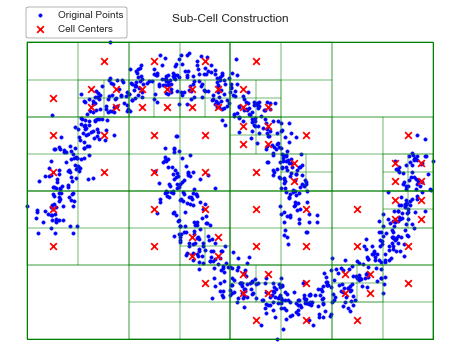

In [109]:
S_moons = coreset_construction(moons, k, d, eps, len(moons)); 

# K means for moons

C:\Users\Stasius\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


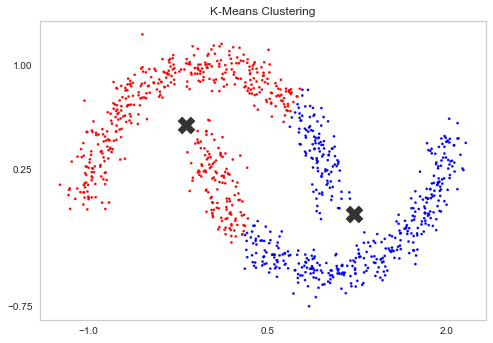

In [62]:
kmeans_moons = KMeans(n_clusters=2, random_state=0)
y_kmeans_moons = kmeans_moons.fit_predict(moons)

plt.scatter(moons[:, 0], moons[:, 1], c=y_kmeans_moons, s=5, cmap='bwr')
centers_moons = kmeans_moons.cluster_centers_
plt.scatter(centers_moons[:, 0], centers_moons[:, 1], c='black', s=300, alpha=0.8, marker='X')
plt.title('K-Means Clustering')
plt.grid(which='major')

x_ticks = [-1,0.5,2]
plt.xticks(x_ticks)

y_ticks = [-0.75,0.25,1]
plt.yticks(y_ticks)
plt.show()

In [18]:
silhouette_score_moons = metrics.silhouette_score(moons, y_kmeans_moons)
inertia_moons = kmeans_moons.inertia_

print(f"Silhouette Score: {silhouette_score_moons}") #how well-separated the clusters are
print(f"Inertia: {inertia_moons}") # how far the points within a cluster are from the center of that cluster.

Silhouette Score: 0.49118118873967026
Inertia: 404.38951595744743


# K means for coreset of moons

In [19]:
coordinates_moons = np.array([item[0] for item in S_moons])
coreset_array_moons = coordinates_moons.reshape(-1, 2)
coreset_array_moons[0:5]

array([[ 0.248375 , -0.378875 ],
       [-1.027375 , -0.132125 ],
       [-1.027375 ,  0.114625 ],
       [-0.176875 , -0.132125 ],
       [ 0.1420625, -0.1938125]])

C:\Users\Stasius\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


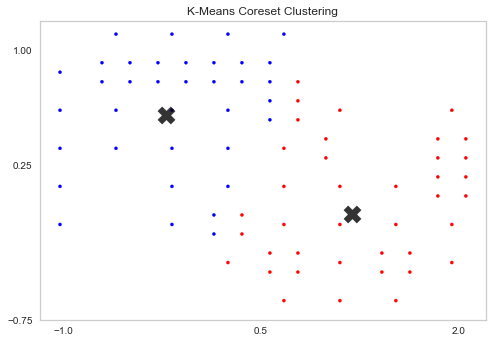

In [68]:
corekmeans_moons = KMeans(n_clusters=2, random_state=0)
y_corekmeans_moons = corekmeans_moons.fit_predict(coreset_array_moons, sample_weight= [item[1] for item in S_moons])

plt.scatter(coreset_array_moons[:, 0], coreset_array_moons[:, 1], c=y_corekmeans_moons, s=10, cmap='bwr')
corecenters_moons = corekmeans_moons.cluster_centers_
plt.scatter(corecenters_moons[:, 0], corecenters_moons[:, 1], c='black', s=300, alpha=0.8, marker='X')
plt.title('K-Means Coreset Clustering')
plt.grid(which='major')

x_ticks = [-1,0.5,2]
plt.xticks(x_ticks)

y_ticks = [-0.75,0.25,1]
plt.yticks(y_ticks)
plt.show()

In [21]:
silhouette_score_core_moons = metrics.silhouette_score(coreset_array_moons, y_corekmeans_moons)
inertia_core_moons = corekmeans_moons.inertia_

print(f"Silhouette Score: {silhouette_score_core_moons}") #how well-separated the clusters are
print(f"Inertia: {inertia_core_moons}") # how far the points within a cluster are from the center of that cluster.

Silhouette Score: 0.4474386204343666
Inertia: 419.6089095808409


# Circles

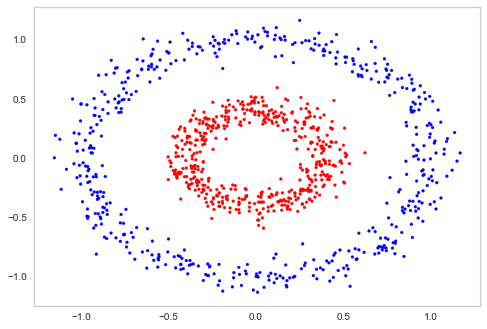

In [108]:
circles, circles_labels = sk.datasets.make_circles(n_samples=n, random_state=1, noise = 0.07, factor=0.4)
circles = circles.round(3)
plt.scatter(circles[:, 0], circles[:, 1], c=circles_labels, cmap="bwr", s=8)
plt.grid(which='major');

The array is non-empty, proceeding with coreset construction algorithm
delta = 6
cs = 72
Number of guesses for opt approximation = 94

Iteration j = 0, with approximation Opt = (1+eps)^j = 1.0

Threshold value: 0.09375 Points in cell: 998
Threshold value: 0.1875 Points in cell: 253
Threshold value: 0.375 Points in cell: 25
Threshold value: 0.75 Points in cell: 0
Threshold value: 0.75 Points in cell: 3
Threshold value: 1.5 Points in cell: 0
Threshold value: 1.5 Points in cell: 0
Threshold value: 1.5 Points in cell: 0
Threshold value: 1.5 Points in cell: 3
Threshold value: 3.0 Points in cell: 0
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 1
Threshold value: 0.75 Points in cell: 4
Threshold value: 1.5 Points in cell: 0
Threshold value: 1.5 Points in cell: 1
Threshold value: 1.5 Points in cell: 0
Threshold value: 1.5 Points in cell: 3
Threshold value: 3.0 Points in cell: 0
Threshold value: 3.0 Points in cell: 1
Threshold

Threshold value: 3.0 Points in cell: 2
Threshold value: 3.0 Points in cell: 0
Threshold value: 3.0 Points in cell: 0
Threshold value: 1.5 Points in cell: 13
Threshold value: 3.0 Points in cell: 4
Threshold value: 6.0 Points in cell: 0
Threshold value: 6.0 Points in cell: 3
Threshold value: 6.0 Points in cell: 1
Threshold value: 6.0 Points in cell: 0
Threshold value: 3.0 Points in cell: 8
Threshold value: 6.0 Points in cell: 2
Threshold value: 6.0 Points in cell: 3
Threshold value: 6.0 Points in cell: 0
Threshold value: 6.0 Points in cell: 3
Threshold value: 3.0 Points in cell: 0
Threshold value: 3.0 Points in cell: 1
Threshold value: 0.375 Points in cell: 26
Threshold value: 0.75 Points in cell: 1
Threshold value: 1.5 Points in cell: 0
Threshold value: 1.5 Points in cell: 1
Threshold value: 1.5 Points in cell: 0
Threshold value: 1.5 Points in cell: 0
Threshold value: 0.75 Points in cell: 22
Threshold value: 1.5 Points in cell: 6
Threshold value: 3.0 Points in cell: 0
Threshold value: 3

Threshold value: 6.6 Points in cell: 3
Threshold value: 6.6 Points in cell: 3
Threshold value: 1.65 Points in cell: 3
Threshold value: 3.3 Points in cell: 3
Threshold value: 3.3 Points in cell: 0
Threshold value: 3.3 Points in cell: 0
Threshold value: 3.3 Points in cell: 0
Threshold value: 1.65 Points in cell: 17
Threshold value: 3.3 Points in cell: 1
Threshold value: 3.3 Points in cell: 3
Threshold value: 3.3 Points in cell: 5
Threshold value: 6.6 Points in cell: 0
Threshold value: 6.6 Points in cell: 4
Threshold value: 6.6 Points in cell: 1
Threshold value: 6.6 Points in cell: 0
Threshold value: 3.3 Points in cell: 8
Threshold value: 6.6 Points in cell: 5
Threshold value: 6.6 Points in cell: 2
Threshold value: 6.6 Points in cell: 1
Threshold value: 6.6 Points in cell: 0
Threshold value: 1.65 Points in cell: 8
Threshold value: 3.3 Points in cell: 3
Threshold value: 3.3 Points in cell: 0
Threshold value: 3.3 Points in cell: 4
Threshold value: 6.6 Points in cell: 0
Threshold value: 6.6 

Threshold value: 7.26 Points in cell: 0
Threshold value: 3.63 Points in cell: 5
Threshold value: 7.26 Points in cell: 2
Threshold value: 7.26 Points in cell: 0
Threshold value: 7.26 Points in cell: 1
Threshold value: 7.26 Points in cell: 2
Threshold value: 1.815 Points in cell: 21
Threshold value: 3.63 Points in cell: 7
Threshold value: 7.26 Points in cell: 3
Threshold value: 7.26 Points in cell: 1
Threshold value: 7.26 Points in cell: 3
Threshold value: 7.26 Points in cell: 0
Threshold value: 3.63 Points in cell: 4
Threshold value: 7.26 Points in cell: 0
Threshold value: 7.26 Points in cell: 2
Threshold value: 7.26 Points in cell: 1
Threshold value: 7.26 Points in cell: 1
Threshold value: 3.63 Points in cell: 6
Threshold value: 7.26 Points in cell: 1
Threshold value: 7.26 Points in cell: 2
Threshold value: 7.26 Points in cell: 0
Threshold value: 7.26 Points in cell: 3
Threshold value: 3.63 Points in cell: 4
Threshold value: 7.26 Points in cell: 1
Threshold value: 7.26 Points in cell: 

Threshold value: 7.986 Points in cell: 0
Threshold value: 1.9965 Points in cell: 13
Threshold value: 3.993 Points in cell: 0
Threshold value: 3.993 Points in cell: 8
Threshold value: 7.986 Points in cell: 2
Threshold value: 7.986 Points in cell: 5
Threshold value: 7.986 Points in cell: 1
Threshold value: 7.986 Points in cell: 0
Threshold value: 3.993 Points in cell: 1
Threshold value: 3.993 Points in cell: 4
Threshold value: 7.986 Points in cell: 2
Threshold value: 7.986 Points in cell: 0
Threshold value: 7.986 Points in cell: 0
Threshold value: 7.986 Points in cell: 2
Threshold value: 1.9965 Points in cell: 19
Threshold value: 3.993 Points in cell: 6
Threshold value: 7.986 Points in cell: 0
Threshold value: 7.986 Points in cell: 1
Threshold value: 7.986 Points in cell: 2
Threshold value: 7.986 Points in cell: 3
Threshold value: 3.993 Points in cell: 8
Threshold value: 7.986 Points in cell: 2
Threshold value: 7.986 Points in cell: 2
Threshold value: 7.986 Points in cell: 4
Threshold va

Threshold value: 4.3923 Points in cell: 0
Threshold value: 4.3923 Points in cell: 1
Threshold value: 4.3923 Points in cell: 0
Threshold value: 4.3923 Points in cell: 4
Threshold value: 1.09808 Points in cell: 43
Threshold value: 2.19615 Points in cell: 5
Threshold value: 4.3923 Points in cell: 1
Threshold value: 4.3923 Points in cell: 0
Threshold value: 4.3923 Points in cell: 1
Threshold value: 4.3923 Points in cell: 3
Threshold value: 2.19615 Points in cell: 5
Threshold value: 4.3923 Points in cell: 0
Threshold value: 4.3923 Points in cell: 0
Threshold value: 4.3923 Points in cell: 3
Threshold value: 4.3923 Points in cell: 2
Threshold value: 2.19615 Points in cell: 20
Threshold value: 4.3923 Points in cell: 6
Threshold value: 8.7846 Points in cell: 1
Threshold value: 8.7846 Points in cell: 2
Threshold value: 8.7846 Points in cell: 1
Threshold value: 8.7846 Points in cell: 2
Threshold value: 4.3923 Points in cell: 5
Threshold value: 8.7846 Points in cell: 2
Threshold value: 8.7846 Poin

Threshold value: 9.66306 Points in cell: 3
Threshold value: 4.83153 Points in cell: 8
Threshold value: 9.66306 Points in cell: 2
Threshold value: 9.66306 Points in cell: 2
Threshold value: 9.66306 Points in cell: 4
Threshold value: 9.66306 Points in cell: 0
Threshold value: 4.83153 Points in cell: 2
Threshold value: 4.83153 Points in cell: 3
Threshold value: 1.20788 Points in cell: 14
Threshold value: 2.41577 Points in cell: 9
Threshold value: 4.83153 Points in cell: 3
Threshold value: 4.83153 Points in cell: 3
Threshold value: 4.83153 Points in cell: 3
Threshold value: 4.83153 Points in cell: 0
Threshold value: 2.41577 Points in cell: 5
Threshold value: 4.83153 Points in cell: 3
Threshold value: 4.83153 Points in cell: 2
Threshold value: 4.83153 Points in cell: 0
Threshold value: 4.83153 Points in cell: 0
Threshold value: 2.41577 Points in cell: 0
Threshold value: 2.41577 Points in cell: 0
Threshold value: 0.30197 Points in cell: 262
Threshold value: 0.60394 Points in cell: 53
Thresho

Threshold value: 2.65734 Points in cell: 8
Threshold value: 5.31468 Points in cell: 2
Threshold value: 5.31468 Points in cell: 1
Threshold value: 5.31468 Points in cell: 5
Threshold value: 5.31468 Points in cell: 0
Threshold value: 2.65734 Points in cell: 5
Threshold value: 5.31468 Points in cell: 1
Threshold value: 5.31468 Points in cell: 1
Threshold value: 5.31468 Points in cell: 1
Threshold value: 5.31468 Points in cell: 2
Threshold value: 2.65734 Points in cell: 6
Threshold value: 5.31468 Points in cell: 3
Threshold value: 5.31468 Points in cell: 0
Threshold value: 5.31468 Points in cell: 2
Threshold value: 5.31468 Points in cell: 1
Threshold value: 1.32867 Points in cell: 2
Threshold value: 2.65734 Points in cell: 0
Threshold value: 2.65734 Points in cell: 0
Threshold value: 2.65734 Points in cell: 2
Threshold value: 2.65734 Points in cell: 0
Threshold value: 0.66434 Points in cell: 132
Threshold value: 1.32867 Points in cell: 59
Threshold value: 2.65734 Points in cell: 9
Threshol

Threshold value: 5.84615 Points in cell: 0
Threshold value: 5.84615 Points in cell: 2
Threshold value: 2.92308 Points in cell: 19
Threshold value: 5.84615 Points in cell: 5
Threshold value: 5.84615 Points in cell: 8
Threshold value: 11.6923 Points in cell: 0
Threshold value: 11.6923 Points in cell: 3
Threshold value: 11.6923 Points in cell: 3
Threshold value: 11.6923 Points in cell: 2
Threshold value: 5.84615 Points in cell: 1
Threshold value: 5.84615 Points in cell: 5
Threshold value: 1.46154 Points in cell: 18
Threshold value: 2.92308 Points in cell: 1
Threshold value: 2.92308 Points in cell: 0
Threshold value: 2.92308 Points in cell: 14
Threshold value: 5.84615 Points in cell: 2
Threshold value: 5.84615 Points in cell: 1
Threshold value: 5.84615 Points in cell: 8
Threshold value: 11.6923 Points in cell: 2
Threshold value: 11.6923 Points in cell: 2
Threshold value: 11.6923 Points in cell: 2
Threshold value: 11.6923 Points in cell: 2
Threshold value: 5.84615 Points in cell: 3
Threshol

Threshold value: 6.43077 Points in cell: 0
Threshold value: 6.43077 Points in cell: 3
Threshold value: 3.21538 Points in cell: 5
Threshold value: 6.43077 Points in cell: 0
Threshold value: 6.43077 Points in cell: 0
Threshold value: 6.43077 Points in cell: 3
Threshold value: 6.43077 Points in cell: 2
Threshold value: 3.21538 Points in cell: 7
Threshold value: 6.43077 Points in cell: 4
Threshold value: 6.43077 Points in cell: 1
Threshold value: 6.43077 Points in cell: 1
Threshold value: 6.43077 Points in cell: 1
Threshold value: 3.21538 Points in cell: 1
Threshold value: 1.60769 Points in cell: 16
Threshold value: 3.21538 Points in cell: 12
Threshold value: 6.43077 Points in cell: 2
Threshold value: 6.43077 Points in cell: 4
Threshold value: 6.43077 Points in cell: 4
Threshold value: 6.43077 Points in cell: 2
Threshold value: 3.21538 Points in cell: 2
Threshold value: 3.21538 Points in cell: 1
Threshold value: 3.21538 Points in cell: 1
Threshold value: 0.80385 Points in cell: 28
Threshol

Threshold value: 7.78123 Points in cell: 1
Threshold value: 7.78123 Points in cell: 2
Threshold value: 3.89061 Points in cell: 6
Threshold value: 7.78123 Points in cell: 3
Threshold value: 7.78123 Points in cell: 0
Threshold value: 7.78123 Points in cell: 2
Threshold value: 7.78123 Points in cell: 1
Threshold value: 1.94531 Points in cell: 2
Threshold value: 3.89061 Points in cell: 0
Threshold value: 3.89061 Points in cell: 0
Threshold value: 3.89061 Points in cell: 2
Threshold value: 3.89061 Points in cell: 0
Threshold value: 0.97265 Points in cell: 132
Threshold value: 1.94531 Points in cell: 59
Threshold value: 3.89061 Points in cell: 9
Threshold value: 7.78123 Points in cell: 3
Threshold value: 7.78123 Points in cell: 0
Threshold value: 7.78123 Points in cell: 4
Threshold value: 7.78123 Points in cell: 2
Threshold value: 3.89061 Points in cell: 4
Threshold value: 7.78123 Points in cell: 0
Threshold value: 7.78123 Points in cell: 0
Threshold value: 7.78123 Points in cell: 2
Threshol

Threshold value: 8.55935 Points in cell: 3
Threshold value: 8.55935 Points in cell: 3
Threshold value: 2.13984 Points in cell: 18
Threshold value: 4.27968 Points in cell: 5
Threshold value: 8.55935 Points in cell: 2
Threshold value: 8.55935 Points in cell: 0
Threshold value: 8.55935 Points in cell: 0
Threshold value: 8.55935 Points in cell: 3
Threshold value: 4.27968 Points in cell: 5
Threshold value: 8.55935 Points in cell: 0
Threshold value: 8.55935 Points in cell: 0
Threshold value: 8.55935 Points in cell: 3
Threshold value: 8.55935 Points in cell: 2
Threshold value: 4.27968 Points in cell: 7
Threshold value: 8.55935 Points in cell: 4
Threshold value: 8.55935 Points in cell: 1
Threshold value: 8.55935 Points in cell: 1
Threshold value: 8.55935 Points in cell: 1
Threshold value: 4.27968 Points in cell: 1
Threshold value: 2.13984 Points in cell: 16
Threshold value: 4.27968 Points in cell: 12
Threshold value: 8.55935 Points in cell: 2
Threshold value: 8.55935 Points in cell: 4
Threshol

Threshold value: 5.17841 Points in cell: 5
Threshold value: 5.17841 Points in cell: 1
Threshold value: 2.5892 Points in cell: 2
Threshold value: 2.5892 Points in cell: 14
Threshold value: 5.17841 Points in cell: 5
Threshold value: 5.17841 Points in cell: 8
Threshold value: 10.35681 Points in cell: 2
Threshold value: 10.35681 Points in cell: 4
Threshold value: 10.35681 Points in cell: 2
Threshold value: 10.35681 Points in cell: 0
Threshold value: 5.17841 Points in cell: 0
Threshold value: 5.17841 Points in cell: 1
Threshold value: 2.5892 Points in cell: 22
Threshold value: 5.17841 Points in cell: 11
Threshold value: 10.35681 Points in cell: 2
Threshold value: 10.35681 Points in cell: 1
Threshold value: 10.35681 Points in cell: 4
Threshold value: 10.35681 Points in cell: 4
Threshold value: 5.17841 Points in cell: 4
Threshold value: 5.17841 Points in cell: 2
Threshold value: 5.17841 Points in cell: 5
Threshold value: 0.6473 Points in cell: 238
Threshold value: 1.2946 Points in cell: 114
T

Threshold value: 6.26587 Points in cell: 13
Threshold value: 12.53174 Points in cell: 5
Threshold value: 12.53174 Points in cell: 4
Threshold value: 12.53174 Points in cell: 2
Threshold value: 12.53174 Points in cell: 2
Threshold value: 6.26587 Points in cell: 3
Threshold value: 6.26587 Points in cell: 4
Threshold value: 3.13294 Points in cell: 10
Threshold value: 6.26587 Points in cell: 9
Threshold value: 12.53174 Points in cell: 4
Threshold value: 12.53174 Points in cell: 2
Threshold value: 12.53174 Points in cell: 3
Threshold value: 12.53174 Points in cell: 0
Threshold value: 6.26587 Points in cell: 0
Threshold value: 6.26587 Points in cell: 0
Threshold value: 6.26587 Points in cell: 1
Threshold value: 1.56647 Points in cell: 46
Threshold value: 3.13294 Points in cell: 3
Threshold value: 3.13294 Points in cell: 21
Threshold value: 6.26587 Points in cell: 6
Threshold value: 6.26587 Points in cell: 5
Threshold value: 6.26587 Points in cell: 8
Threshold value: 12.53174 Points in cell: 

Threshold value: 16.67975 Points in cell: 10
Threshold value: 16.67975 Points in cell: 4
Threshold value: 16.67975 Points in cell: 4
Threshold value: 8.33988 Points in cell: 13
Threshold value: 16.67975 Points in cell: 0
Threshold value: 16.67975 Points in cell: 8
Threshold value: 16.67975 Points in cell: 1
Threshold value: 16.67975 Points in cell: 4
Threshold value: 8.33988 Points in cell: 19
Threshold value: 16.67975 Points in cell: 6
Threshold value: 16.67975 Points in cell: 8
Threshold value: 16.67975 Points in cell: 2
Threshold value: 16.67975 Points in cell: 3
Threshold value: 4.16994 Points in cell: 14
Threshold value: 8.33988 Points in cell: 9
Threshold value: 16.67975 Points in cell: 3
Threshold value: 16.67975 Points in cell: 3
Threshold value: 16.67975 Points in cell: 3
Threshold value: 16.67975 Points in cell: 0
Threshold value: 8.33988 Points in cell: 5
Threshold value: 8.33988 Points in cell: 0
Threshold value: 8.33988 Points in cell: 0
Threshold value: 1.04248 Points in 

Threshold value: 2.77509 Points in cell: 127
Threshold value: 5.55019 Points in cell: 6
Threshold value: 11.10037 Points in cell: 0
Threshold value: 11.10037 Points in cell: 0
Threshold value: 11.10037 Points in cell: 1
Threshold value: 11.10037 Points in cell: 5
Threshold value: 5.55019 Points in cell: 43
Threshold value: 11.10037 Points in cell: 5
Threshold value: 11.10037 Points in cell: 5
Threshold value: 11.10037 Points in cell: 20
Threshold value: 22.20075 Points in cell: 6
Threshold value: 22.20075 Points in cell: 5
Threshold value: 22.20075 Points in cell: 6
Threshold value: 22.20075 Points in cell: 3
Threshold value: 11.10037 Points in cell: 13
Threshold value: 22.20075 Points in cell: 5
Threshold value: 22.20075 Points in cell: 4
Threshold value: 22.20075 Points in cell: 1
Threshold value: 22.20075 Points in cell: 3
Threshold value: 5.55019 Points in cell: 64
Threshold value: 11.10037 Points in cell: 8
Threshold value: 11.10037 Points in cell: 24
Threshold value: 22.20075 Poi

Threshold value: 3.69365 Points in cell: 123
Threshold value: 7.3873 Points in cell: 47
Threshold value: 14.7746 Points in cell: 3
Threshold value: 14.7746 Points in cell: 20
Threshold value: 29.5492 Points in cell: 4
Threshold value: 29.5492 Points in cell: 3
Threshold value: 29.5492 Points in cell: 5
Threshold value: 29.5492 Points in cell: 8
Threshold value: 14.7746 Points in cell: 5
Threshold value: 14.7746 Points in cell: 19
Threshold value: 29.5492 Points in cell: 5
Threshold value: 29.5492 Points in cell: 8
Threshold value: 29.5492 Points in cell: 1
Threshold value: 29.5492 Points in cell: 5
Threshold value: 7.3873 Points in cell: 18
Threshold value: 14.7746 Points in cell: 1
Threshold value: 14.7746 Points in cell: 0
Threshold value: 14.7746 Points in cell: 14
Threshold value: 14.7746 Points in cell: 3
Threshold value: 7.3873 Points in cell: 10
Threshold value: 14.7746 Points in cell: 0
Threshold value: 14.7746 Points in cell: 10
Threshold value: 14.7746 Points in cell: 0
Thres

Threshold value: 21.63149 Points in cell: 1
Threshold value: 10.81575 Points in cell: 4
Threshold value: 10.81575 Points in cell: 18
Threshold value: 21.63149 Points in cell: 7
Threshold value: 21.63149 Points in cell: 2
Threshold value: 21.63149 Points in cell: 7
Threshold value: 21.63149 Points in cell: 2
Threshold value: 2.70394 Points in cell: 245
Threshold value: 5.40787 Points in cell: 51
Threshold value: 10.81575 Points in cell: 20
Threshold value: 21.63149 Points in cell: 3
Threshold value: 21.63149 Points in cell: 8
Threshold value: 21.63149 Points in cell: 4
Threshold value: 21.63149 Points in cell: 5
Threshold value: 10.81575 Points in cell: 0
Threshold value: 10.81575 Points in cell: 14
Threshold value: 21.63149 Points in cell: 0
Threshold value: 21.63149 Points in cell: 7
Threshold value: 21.63149 Points in cell: 1
Threshold value: 21.63149 Points in cell: 6
Threshold value: 10.81575 Points in cell: 17
Threshold value: 21.63149 Points in cell: 5
Threshold value: 21.63149 P

Threshold value: 34.83773 Points in cell: 0
Threshold value: 34.83773 Points in cell: 3
Threshold value: 34.83773 Points in cell: 4
Threshold value: 34.83773 Points in cell: 11
Threshold value: 17.41887 Points in cell: 40
Threshold value: 34.83773 Points in cell: 21
Threshold value: 34.83773 Points in cell: 5
Threshold value: 34.83773 Points in cell: 13
Threshold value: 34.83773 Points in cell: 1
Threshold value: 17.41887 Points in cell: 46
Threshold value: 34.83773 Points in cell: 26
Threshold value: 34.83773 Points in cell: 13
Threshold value: 34.83773 Points in cell: 3
Threshold value: 34.83773 Points in cell: 4
Threshold value: 17.41887 Points in cell: 10
Threshold value: 8.70943 Points in cell: 46
Threshold value: 17.41887 Points in cell: 3
Threshold value: 17.41887 Points in cell: 21
Threshold value: 34.83773 Points in cell: 6
Threshold value: 34.83773 Points in cell: 5
Threshold value: 34.83773 Points in cell: 8
Threshold value: 34.83773 Points in cell: 2
Threshold value: 17.418

Threshold value: 37.33889 Points in cell: 4
Threshold value: 37.33889 Points in cell: 18
Threshold value: 9.33472 Points in cell: 245
Threshold value: 18.66944 Points in cell: 51
Threshold value: 37.33889 Points in cell: 20
Threshold value: 37.33889 Points in cell: 0
Threshold value: 37.33889 Points in cell: 14
Threshold value: 37.33889 Points in cell: 17
Threshold value: 18.66944 Points in cell: 123
Threshold value: 37.33889 Points in cell: 47
Threshold value: 74.67777 Points in cell: 3
Threshold value: 74.67777 Points in cell: 20
Threshold value: 74.67777 Points in cell: 5
Threshold value: 74.67777 Points in cell: 19
Threshold value: 37.33889 Points in cell: 18
Threshold value: 37.33889 Points in cell: 10
Threshold value: 37.33889 Points in cell: 48
Threshold value: 74.67777 Points in cell: 17
Threshold value: 74.67777 Points in cell: 15
Threshold value: 74.67777 Points in cell: 3
Threshold value: 74.67777 Points in cell: 13
Threshold value: 18.66944 Points in cell: 26
Threshold valu

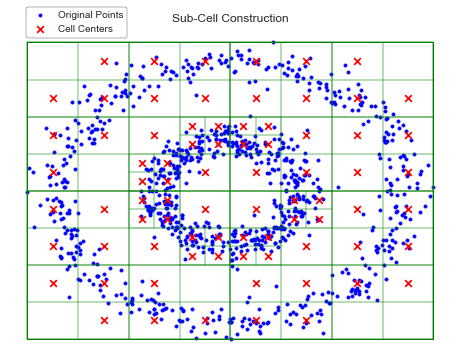

In [110]:
S_circles = coreset_construction(circles, k, d, eps, len(circles));

# K means for circles

C:\Users\Stasius\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


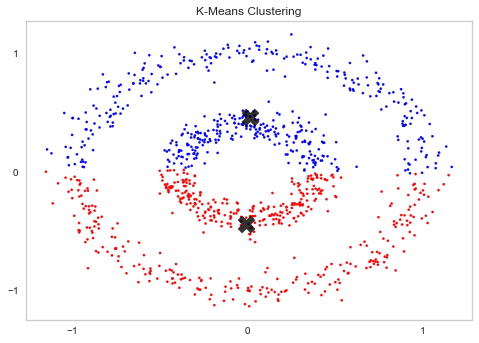

In [58]:
kmeans_circles = KMeans(n_clusters=2, random_state=0)
y_kmeans_circles = kmeans_circles.fit_predict(circles)

plt.scatter(circles[:, 0], circles[:, 1], c=y_kmeans_circles, s=5, cmap='bwr')
centers_circles = kmeans_circles.cluster_centers_
plt.scatter(centers_circles[:, 0], centers_circles[:, 1], c='black', s=300, alpha=0.8, marker='X')
plt.title('K-Means Clustering')
plt.grid(which='major')

x_ticks = [-1,0,1]
plt.xticks(x_ticks)

y_ticks = [-1,0,1]
plt.yticks(y_ticks)

plt.show()

In [25]:
silhouette_score_circles = metrics.silhouette_score(circles, y_kmeans_circles)
inertia_circles = kmeans_circles.inertia_

print(f"Silhouette Score: {silhouette_score_circles}") #how well-separated the clusters are
print(f"Inertia: {inertia_circles}") # how far the points within a cluster are from the center of that cluster.

Silhouette Score: 0.32911178578558076
Inertia: 387.4881602338114


# K means for coreset of circles

In [26]:
coordinates_circles = np.array([item[0] for item in S_circles])
coreset_array_circles = coordinates_circles.reshape(-1, 2)
coreset_array_circles[0:5]

array([[-0.7171875, -0.9896875],
       [-1.0070625, -0.7030625],
       [-0.7171875, -0.7030625],
       [-0.4273125, -0.9896875],
       [-0.1374375, -0.9896875]])

C:\Users\Stasius\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


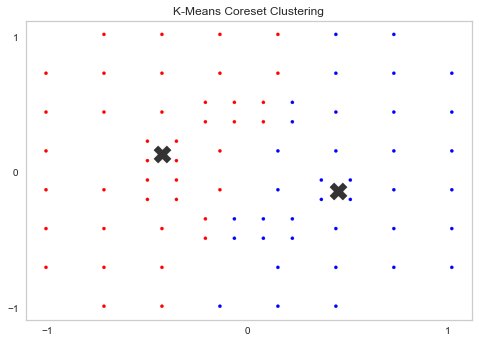

In [55]:
corekmeans_circles = KMeans(n_clusters=2, random_state=0)
y_corekmeans_circles = corekmeans_circles.fit_predict(coreset_array_circles, sample_weight= [item[1] for item in S_circles])

plt.scatter(coreset_array_circles[:, 0], coreset_array_circles[:, 1], c=y_corekmeans_circles, s=10, cmap='bwr')
corecenters_circles = corekmeans_circles.cluster_centers_
plt.scatter(corecenters_circles[:, 0], corecenters_circles[:, 1], c='black', s=300, alpha=0.8, marker='X')
plt.title('K-Means Coreset Clustering')
plt.grid(which='major')

x_ticks = [-1,0,1]
plt.xticks(x_ticks)

y_ticks = [-1,0,1]
plt.yticks(y_ticks)

plt.show()

In [28]:
silhouette_score_circles = metrics.silhouette_score(coreset_array_circles, y_corekmeans_circles)
inertia_circles = corekmeans_circles.inertia_

print(f"Silhouette Score: {silhouette_score_circles}") #how well-separated the clusters are
print(f"Inertia: {inertia_circles}") # how far the points within a cluster are from the center of that cluster.

Silhouette Score: 0.3143619172904558
Inertia: 400.0726739410235


## Silhouette analysis

In [ ]:
def plot_silhouette_analysis(data, clusterer, cluster_labels, n_clusters, ax):
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(cluster_labels) + (n_clusters + 1) * 10])

    silhouette_avg = metrics.silhouette_score(data, cluster_labels, metric='manhattan')

    sample_silhouette_values = metrics.silhouette_samples(data, cluster_labels)

    y_lower = 10
    for j in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(j) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))
        
        y_lower = y_upper + 10

    ax.set_title(f"Silhouette plot, KMeans, n_clusters = {n_clusters}")
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster Label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [ ]:
# Example usage:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

# Assuming clusterer and cluster_labels are computed outside the function
#for i, n_clusters in enumerate([2, 3, 4, 5, 6, 7]):
plot_silhouette_analysis(X, kmedians_instance, y_kmedians, k, axs[0])
plot_silhouette_analysis(X, kmedians_instance, y_kmedians, k, axs[1])
    #kmedians_instance, cluster_labels, n_clusters, axs[i]
    
plt.suptitle(f'Silhouette analysis for KMedians clustering, n = {n}', fontsize=14)
plt.tight_layout()
plt.show()

## commented out

In [ ]:
# #testing
# #from sklearn.metrics import silhouette_samples, silhouette_score
# # X, y = make_blobs(

# range_n_clusters = [1, 2]

# for n_clusters in range_n_clusters:
#     # Create a subplot with 1 row and 2 columns
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.set_size_inches(15, 10)

#     # The 1st subplot is the silhouette plot
#     # The silhouette coefficient can range from -1, 1 but in this example all
#     # lie within [-0.1, 1]
#     ax1.set_xlim([-0.1, 1])
#     # The (n_clusters+1)*10 is for inserting blank space between silhouette
#     # plots of individual clusters, to demarcate them clearly.
#     ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

#     # Initialize the clusterer with n_clusters value and a random generator
#     # seed of 10 for reproducibility.
#     clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
#     cluster_labels = clusterer.fit_predict(X)

#     # The silhouette_score gives the average value for all the samples.
#     # This gives a perspective into the density and separation of the formed
#     # clusters
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print(
#         "For n_clusters =",
#         n_clusters,
#         "The average silhouette_score is :",
#         silhouette_avg,
#     )

#     # Compute the silhouette scores for each sample
#     sample_silhouette_values = silhouette_samples(X, cluster_labels)

#     y_lower = 10
#     for i in range(n_clusters):
#         # Aggregate the silhouette scores for samples belonging to
#         # cluster i, and sort them
#         ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

#         ith_cluster_silhouette_values.sort()

#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i

#         color = cm.nipy_spectral(float(i) / n_clusters)
#         ax1.fill_betweenx(
#             np.arange(y_lower, y_upper),
#             0,
#             ith_cluster_silhouette_values,
#             facecolor=color,
#             edgecolor=color,
#             alpha=0.7,
#         )

#         # Label the silhouette plots with their cluster numbers at the middle
#         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#     ax1.set_title("The silhouette plot for the various clusters.")
#     ax1.set_xlabel("The silhouette coefficient values")
#     ax1.set_ylabel("Cluster label")

#     # The vertical line for average silhouette score of all the values
#     ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#     ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     plt.suptitle(
#         #"Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
#         f'n = {n}'
#         % n_clusters,
#         fontsize=14)

# plt.show()

In [30]:
# fig, axs = plt.subplots(2, 3, figsize=(15, 10))
# axs = axs.ravel()
# x_range = (-0.3, 0.9)

# #blobs
# visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=axs[0],
#                                   title=f"1. Blobs. Silhouette plot, KMeans n = {X.shape[0]}, k = {k}")
# visualizer.fit(X)
# visualizer.finalize()
# axs[0].set_xlim(x_range)

# #blobs core
# visualizer = SilhouetteVisualizer(corekmeans, colors='yellowbrick', ax=axs[3],
#                                   title=f"4. Blobs. Silhouette plot, KMeans cs = {coreset_array.shape[0]}, k = {k}")
# visualizer.fit(coreset_array)
# visualizer.finalize()
# axs[3].set_xlim(x_range)

# #moons
# visualizer = SilhouetteVisualizer(kmeans_moons, colors='yellowbrick', ax=axs[1],
#                                   title=f"2. Moons. Silhouette plot, KMeans n = {moons.shape[0]}, k = {k}")
# visualizer.fit(moons)
# visualizer.finalize()
# axs[1].set_xlim(x_range)

# #moons core
# visualizer = SilhouetteVisualizer(corekmeans_moons, colors='yellowbrick', ax=axs[4],
#                                   title=f"5. Moons. Silhouette plot, KMeans cs = {coreset_array_moons.shape[0]}, k = {k}")
# visualizer.fit(coreset_array_moons)
# visualizer.finalize()
# axs[4].set_xlim(x_range)

# #circles
# visualizer = SilhouetteVisualizer(kmeans_moons, colors='yellowbrick', ax=axs[2],
#                                   title=f"3. Circles. Silhouette plot, KMeans n = {circles.shape[0]}, k = {k}")
# visualizer.fit(circles)
# visualizer.finalize()
# axs[2].set_xlim(x_range)

# #circles core
# visualizer = SilhouetteVisualizer(corekmeans_circles, colors='yellowbrick', ax=axs[5],
#                                   title=f"6. Circles. Silhouette plot, KMeans cs = {coreset_array_circles.shape[0]}, k = {k}")
# visualizer.fit(coreset_array_circles)
# visualizer.finalize()
# axs[5].set_xlim(x_range)

# fig.suptitle(f'n = {n}', fontsize=14)
# plt.tight_layout()
# plt.show()